# "Variational Autoencoder: learning an underlying distribution and generating new data"
> "Constructing an autoencoder that learns the underlying distribution of the input data, generated from a multi-dimensional smooth function `f=f(x_1,x_2,x_3,x_4)`. This can be used to generate new data, sampling from the learned distribution"

- toc: true
- branch: master
- badges: true
- comments: true
- author: Lorenzo Posti
- categories: [neural network, autoencoder, variational autoencoder, basics, jupyter]


## Variational AutoEncoder (VAE): an algorithm to work with distributions

This notebook deals with generating an `Autoencoder` model to learn the underlying distribution of the data. To do this we have to modify the autoencoder such that the `encoder` does not learn a compressed representation of the input data, but rather it will learn the parameters of the distribution of the data in the latent (compressed) space. 

So the idea is to start from an observed sample of the distribution of the data $P({\bf X})$ and to pass this to the `encoder` which will reduce its dimensionality, i.e. $P({\bf X})\mapsto P'({\bf X}_{\rm c})$ where ${\bf X}\in\mathrm{R}^m$ and ${\bf X}_{\rm c}\in\mathrm{R}^n$ with $n<m$. In other words, in a VAE the `encoder` step does not represent the input data ${\bf X}$ with a `code` ${\bf X}_{\rm c}$, but rather the initial data distribution $P({\bf X})$ with a compressed distribution $P'({\bf X}_{\rm c})$, which we usually need to approximate in some analytic form, e.g. a multi-variate normal $P'({\bf X}_{\rm c})\sim \mathcal{N}(\mu,\Sigma)$.

In [1]:
#collapse-hide
import numpy as np
import matplotlib.pylab as plt
from scipy.special import i0, i1, k0, k1
from torch import tensor
from torch import nn
from torch.nn import functional as F
import torch, math
import random

%config Completer.use_jedi = False
%matplotlib inline

rng = np.random.default_rng()

In [2]:
#collapse-hide
G, H, Dc = 4.301e-9, 70, 200.

def fc(x):
    return np.log(1+x)-x/(1+x)

def Vvir(Mh):
    return np.sqrt((Dc*(H)**2/2)**(1./3.) * (G*Mh)**(2./3.))

def Rvir(Mh):
    rho_c = 3. * (H)**2 / (8. * np.pi * G)
    rho_hat = 4. / 3. * np.pi * Dc * rho_c
    return 1e3 * np.power(Mh / rho_hat, 1./3.)

In [3]:
#collapse-hide

# halo concentration--mass relation
def c(Mh, w_scatter=False, H=70.): 
    if w_scatter: return 10.**(0.905 - 0.101 * (np.log10(Mh*H/100.)-12) + rng.normal(0.0, 0.11, len(Mh)))
    return 10.**(0.905 - 0.101 * (np.log10(Mh*H/100.)-12))

# disc mass--size relation
def getRd_fromMd(Md, w_scatter=False):
    ''' approximate mass-size relation '''
    if w_scatter: return 10**((np.log10(Md)-10.7)*0.3+0.5 + rng.normal(0.0, 0.4, len(Md)))
    return 10**((np.log10(Md)-10.7)*0.3+0.5)

# disc mass--halo mass relation
def getMh_fromMd(Md, w_scatter=False):
    ''' approximate SHMR '''
    if w_scatter: return 10**((np.log10(Md)-10.7)*0.75+12.0 + rng.normal(0.0, 0.25, len(Md)))
    return 10**((np.log10(Md)-10.7)*0.75+12.0)

In [5]:
#collapse-hide
class curveMod():
    def __init__(self, Md, Rd, Mh, cc, rad=np.logspace(-1, np.log10(50), 50)):
        self.G, self.H, self.Dc = 4.301e-9, 70, 200.  # physical constants
        self.Md, self.Rd = Md, Rd
        self.Mh, self.cc = Mh, cc
        self.rad = rad
        
        if hasattr(self.Md, '__len__'):
            self.vdisc = [self._vdisc(self.rad, self.Md[i], self.Rd[i]) for i in range(len(self.Md))]
            self.vdm   = [self._vhalo(self.rad, self.Mh[i], self.cc[i]) for i in range(len(self.Md))]
            self.vc    = [np.sqrt(self.vdisc[i]**2+self.vdm[i]**2) for i in range(len(self.Md))]
        else:
            self.vdisc = self._vdisc(self.rad, self.Md, self.Rd)
            self.vdm   = self._vhalo(self.rad, self.Mh, self.cc)
            self.vc    = np.sqrt(self.vdisc**2+self.vdm**2)
        
    def _fc(self, x): return np.log(1+x)-x/(1+x)
    def _Vvir(self, Mh): return np.sqrt((self.Dc*(self.H)**2/2)**(1./3.) * (self.G*Mh)**(2./3.))
    def _Rvir(self, Mh): return 1e3 * (Mh / (0.5*self.Dc*self.H**2 /self.G))**(1./3.)
    
    def _vhalo(self, R, Mh, cc):
        # circular velocity of the halo component (NFW model)
        rv = self._Rvir(Mh)
        return np.sqrt(self._Vvir(Mh)**2*rv/R*self._fc(cc*R/rv)/self._fc(cc)) 
    
    def _vdisc(self, R, Md, Rd):
        # circular velocity of the disc component (exponential disc)
        y = R/2./Rd
        return np.nan_to_num(np.sqrt(2*4.301e-6*Md/Rd*y**2*(i0(y)*k0(y)-i1(y)*k1(y))))

In [31]:
nsamp = 2000
ms = 10**rng.uniform(9, 12, nsamp)
rd = getRd_fromMd(ms, w_scatter=True)
mh = getMh_fromMd(ms, w_scatter=True)
cc = c(mh, w_scatter=True)

In [32]:
cm=curveMod(ms,rd,mh,cc)

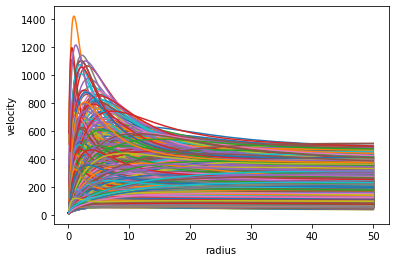

In [33]:
for v in cm.vc: plt.plot(cm.rad, v)
plt.xlabel('radius')
plt.ylabel('velocity');

In [34]:
def datanorm(x):  return (x-x.mean())/x.std(), x.mean(), x.std()
def datascale(x, m, s): return x*s+m

idshuff = torch.randperm(nsamp)
xdata = tensor(cm.vc, dtype=torch.float)[idshuff,:]
xdata, xmean, xstd = datanorm(xdata)

fval = 0.20
xtrain = xdata[:int(nsamp*(1.0-fval))]
xvalid = xdata[int(nsamp*(1.0-fval)):]

In [35]:
class VariationalAutoEncoder(nn.Module):
    def __init__(self, ninp, **kwargs):
        super().__init__()
        self.encodeLayer1 = nn.Linear(in_features=ninp, out_features=32)
        self.encodeLayer2 = nn.Linear(in_features=32,   out_features=16)
        self.encodeOut    = nn.Linear(in_features=16,   out_features=8)
        self.decodeLayer1 = nn.Linear(in_features=4,    out_features=16)
        self.decodeLayer2 = nn.Linear(in_features=16,   out_features=32)
        self.decodeOut    = nn.Linear(in_features=32,   out_features=ninp)
        self.ELBO_loss = None
        
    def encoder(self, x):       
        mean, logvar = torch.split(self.encodeOut(F.relu(self.encodeLayer2(F.relu(self.encodeLayer1(x))))),4,dim=1)
        return mean, logvar
    
    def decoder(self, encoded): return self.decodeOut(F.relu(self.decodeLayer2(F.relu(self.decodeLayer1(encoded)))))
    
    def reparametrize(self, mean, logvar):
        eps = tensor(rng.normal(size=mean.shape), dtype=torch.float)
        return eps * torch.exp(logvar * 0.5) + mean # exp(0.5logvar) = std
    
    # https://towardsdatascience.com/variational-autoencoder-demystified-with-pytorch-implementation-3a06bee395ed
    # https://arxiv.org/pdf/1312.6114.pdf
    # https://stats.stackexchange.com/questions/318748/deriving-the-kl-divergence-loss-for-vaes?noredirect=1&lq=1
    def _ELBO(self, x, decoded, mean, logvar):
        mseloss = nn.MSELoss(reduction='mean')
        logpx_z = -mseloss(x, decoded)
        KLdiv = -0.5 * torch.sum(1 + logvar - mean ** 2 - logvar.exp(), dim = 1)
        return (KLdiv - logpx_z).mean()
        
    def forward(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        decoded = self.decoder(z)
        self.ELBO_loss = self._ELBO(x, decoded, mean, logvar)
        
        return decoded
    
    def getELBO_loss(self, x):
        mean, logvar = self.encoder(x)
        z = self.reparametrize(mean, logvar)
        decoded = self.decoder(z)
        return self._ELBO(x, decoded, mean, logvar)
        

Ok, so there's a lot to break down here!

- First of all, we notice that the overall structure of the encoder/decoder network is relatively similar to the `autoencoder` we saw before, with the important difference that the encoder now returns 8 parameters instead of 4. These are the parameters of the multi-variate normal distribution with which we represent the 4-dimensional latent space, so mean and variance for each of the four physical properties that generate the rotation curves. Thus, the encoder step does not output a `code`, but means and variances for each physical property.
- the decoder step is instead totally similar to a simple `autoencoder` and in fact it requires a `code` as an input. In order to generate a code from the means and variances that come out of the encoder phase without breaking the backprop flow of the algorithm, [Kingma & Welling (2013)](https://arxiv.org/pdf/1312.6114.pdf) proposed to use a *reparametrization trick*, which consists of throwing a new sample from a standard normal and then shifting this to have the same mean and variance as given by the encoder.
- the `forward` method of this class follows these steps: the encoder gives means and variances of the latent space, the reparametrization trick is used to generate a `code`, which is finally decoded by the decoder.
- the appropriate loss function for a variational autoencoder is the **Evidence Lower BOund [(ELBO)](https://en.wikipedia.org/wiki/Evidence_lower_bound)**. In fact, minimising the -ELBO means maximising a lower bound on the evidence or likelihood of the model. The evidence, or reconstruction loss, is `logpx_z` which is just an `MSE` loss on the data and the decoded output of the autoencoder. This term encourages the reconstruction of the dataset and tends to prefer separated encodings for each element of the dataset. The other term is the [Kullback-Leibler divergence](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence) of the proposed distribution in the latent space with the likelihood. This term has the opposite effect of promoting overlapping encodings for separate observations. For this reason, maximising ELBO guarantees to achieve a nice compromise between representing the original data and the ability to generalize by generating *realistic* new data.

In [36]:
vae = VariationalAutoEncoder(len(cm.rad))

# Adam and MSE Loss
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-2)

for epoch in range(2000):
    ymod = vae.forward(xtrain)
    loss = vae.ELBO_loss
    
    loss.backward()
    
    optimizer.step()
    
    optimizer.zero_grad()
    
#     print (epoch, "train L:%1.2e" % loss, "  valid L:%1.2e" % vae.getELBO_loss(xvalid))
    if epoch%100==0: print (epoch, "train L:%1.2e" % loss, "  valid L:%1.2e" % vae.getELBO_loss(xvalid))

0 train L:1.18e+00   valid L:1.05e+00
100 train L:7.82e-01   valid L:7.79e-01
200 train L:7.82e-01   valid L:7.79e-01
300 train L:7.82e-01   valid L:7.79e-01
400 train L:7.82e-01   valid L:7.78e-01
500 train L:7.82e-01   valid L:7.78e-01
600 train L:7.82e-01   valid L:7.78e-01
700 train L:7.81e-01   valid L:7.78e-01
800 train L:7.81e-01   valid L:7.79e-01
900 train L:7.81e-01   valid L:7.79e-01
1000 train L:7.82e-01   valid L:7.78e-01
1100 train L:7.82e-01   valid L:7.78e-01
1200 train L:7.81e-01   valid L:7.78e-01
1300 train L:7.81e-01   valid L:7.79e-01
1400 train L:7.81e-01   valid L:7.78e-01
1500 train L:7.81e-01   valid L:7.78e-01
1600 train L:7.81e-01   valid L:7.73e-01
1700 train L:6.65e-01   valid L:6.91e-01
1800 train L:7.10e-01   valid L:6.60e-01
1900 train L:7.01e-01   valid L:6.60e-01


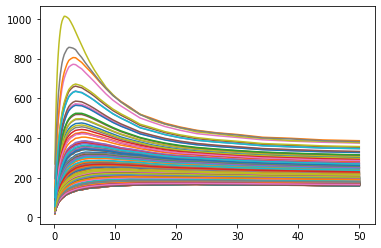

In [37]:
for v in datascale(vae.forward(xvalid),xmean,xstd): plt.plot(cm.rad, v.detach().numpy())

In [48]:
# vae.encoder(xtrain)[0].mean(dim=0).detach(), vae.encoder(xtrain)[0].std(dim=0).detach()
vae.encoder(xtrain)[1].mean(dim=0).detach(), vae.encoder(xtrain)[1].std(dim=0).detach()

(tensor([-6.8946e-03,  8.9814e-05, -3.1334e-01, -1.7957e-03]),
 tensor([0.0068, 0.0096, 0.1728, 0.0028]))